# Activity 5: Assembling a Deep Learning System
In this activity, we will train the first version of our LSTM model using Bitcoin daily closing prices. These prices will be organized using the weeks of both 2016 and 2017. We do that because we are interested in predicting the prices of a week's worth of trading.

In [1]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model

Autosaving every 5 seconds


In [2]:
#  Import training dataset
train = pd.read_csv('/content/train_dataset.csv')
train.head()

,date,iso_week,close,volume,close_point_relative_normalization,volume_point_relative_normalization
0,2016-01-01,2016-00,434.33,36278900.0,0.000000,0.000000
1,2016-01-02,2016-00,433.44,30096600.0,-0.002049,-0.170410
2,2016-01-03,2016-01,430.01,39633800.0,0.000000,0.000000
3,2016-01-04,2016-01,433.09,38477500.0,0.007163,-0.029175
4,2016-01-05,2016-01,431.96,34522600.0,0.004535,-0.128961


## Reshape Data

In [3]:
def create_groups(data, group_size=7):
    """Create distinct groups from a continuous series.
    
    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.
    
    Returns
    -------
    A Numpy array object. 
    """
    samples = []
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size))
    
    return np.array(samples)

In [4]:
#  Find the remainder when the number of observations is divided by group size
len(train) % 7

2

In [5]:
#  Create groups of 7 from our data.
#  We drop the first two observations so that the
#  number of total observations is divisible by the `group_size`.
data = create_groups(train['close_point_relative_normalization'][2:].values)
print(data.shape)

(77, 1, 7)


In [6]:
#  Reshape data into format expected by LSTM layer
X_train = data[:-1, :].reshape(1, 76, 7)
Y_validation = data[-1].reshape(1, 7)
print(X_train.shape)
print(Y_validation.shape)

(1, 76, 7)
(1, 7)


## Load Our Model

In [7]:
#  Load our previously trained model 
model = load_model('bitcoin_lstm_v0.h5')

## Train model

In [8]:
%%time
#  Train the model
history = model.fit(
    x=X_train, y=Y_validation,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 4/100
1/1 [==============================] - 0s 918us/step - loss: 0.0030
Epoch 5/100
1/1 [==============================] - 0s 829us/step - loss: 0.0027
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 9/100
1/1 [==============================] - 0s 930us/step - loss: 0.0018
Epoch 10/100
1/1 [==============================] - 0s 927us/step - loss: 0.0016
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 12/100
1/1 [==============================] - 0s 978us/step - loss: 0.0013
Epoch 13/100
1/1 [==============================] -

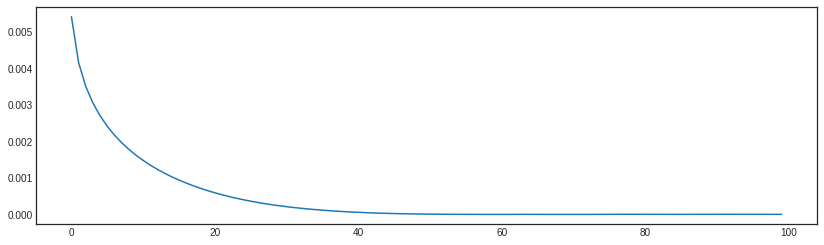

In [9]:
#  Plot loss function
pd.Series(history.history['loss']).plot(figsize=(14, 4));

## Make Predictions

In [10]:
#  Make predictions using X_train data
predictions = model.predict(x=X_train)[0]
predictions

array([-0.00120796,  0.01779516,  0.0664935 ,  0.05382925,  0.06041446,
        0.0758766 ,  0.02596492], dtype=float32)

In [11]:
def denormalize(series, last_value):
    """Denormalize the values for a given series.
    
    This uses the last value available (i.e. the last
    closing price of the week before our prediction)
    as a reference for scaling the predicted results.
    """
    result = last_value * (series + 1)
    return result

In [12]:
#  Denormalize predictions
last_weeks_value = train[train['date'] == train['date'][:-7].max()]['close'].values[0]

denormalized_prediction = denormalize(predictions, last_weeks_value)
denormalized_prediction

array([2652.6716, 2703.1418, 2832.4788, 2798.8438, 2816.3333, 2857.399 ,
       2724.8398], dtype=float32)

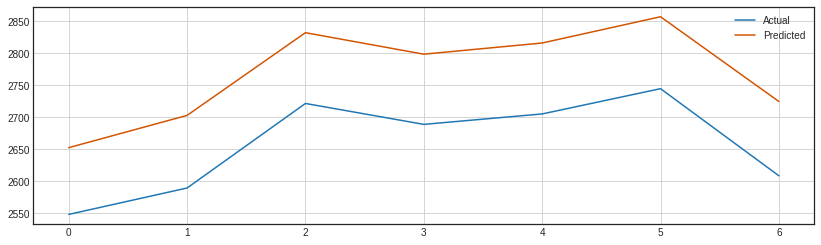

In [13]:
#  Plot denormalized predictions against actual predictions
plt.figure(figsize=(14, 4))

plt.plot(train['close'][-7:].values, label='Actual')
plt.plot(denormalized_prediction, color='#d35400', label='Predicted')

plt.grid()
plt.legend();

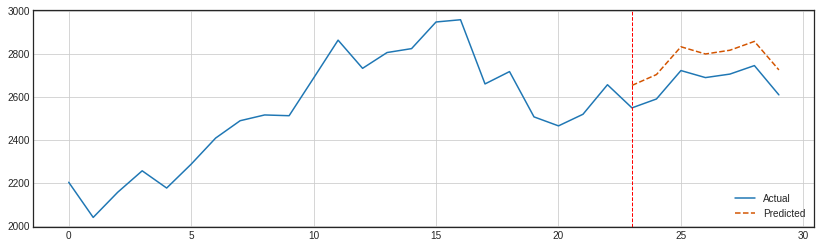

In [14]:
prediction_plot = np.zeros(len(train)-2)
prediction_plot[:] = np.nan
prediction_plot[-7:] = denormalized_prediction

plt.figure(figsize=(14, 4))
plt.plot(train['close'][-30:].values, label='Actual')
plt.plot(prediction_plot[-30:], color='#d35400', linestyle='--', label='Predicted')
plt.axvline(30 - 7, color='r', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='lower right');

In [16]:
#  TASK:
#  Save model to disk
#
model.save('/content/bitcoin_lstm_v0_trained.h5')

In this activity, we have assembled a complete deep learning system: from data to prediction. The model created in this activity need a number of improvements before it can be considered useful. However, it serves as a great starting point from which we will continuously improve.